In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.special import erf
from scipy.spatial import distance_matrix
import pandas as pd
import json
import os

mfSpeeds = {1.:2., 2.:1.08244, 3.:1.02513, 5.:1.00528, 10.:1.00047, 20.:1.00017, 1.5:1.19}

In [2]:
def keepNearest(positionArr, nKeepers):
    '''
    Function that returns the p
    ositions in an array with
    the smallest radii
    
    Inputs
    __________
    
    positionArr : array-like
        array with the cell positions in the form
        np.array([xPositions, yPositions, zPositions, ...])
    nKeepers : int-like
        integer number of points to keep
        
        
        
    Outputs
    __________
    
    nearestLocs : array-like
        the nKeepers members of positionArr that are closest
        to the origin
    '''
    
    # Keep only the nCells points nearest to the origin
    radii = np.linalg.norm(positionArr.T, axis=1)
    keepers = np.argsort(radii)[0:nKeepers]
    nearestLocs = (positionArr.T[keepers]).T
    
    return nearestLocs



def createOrderedArray(nDim, sep, nCells):
    '''
    Function that returns an ordered array of positions
    of cells; if nDim is 1, then the cells are on a line;
    if nDim is 2, then cells are on a disk; if nDim is
    3, then cells are on a sphere.
    
    Inputs
    __________
    
    nDim : int-like
        number of dimensions in which the cells live
    sep : float-like
        separation of cells
    nCells : float-like
        number of cells
        
        
        
    Outputs
    __________
    
    cellPositions : array-like
        array of cell positions in the form of
        np.array([xPositions, yPositions, zPositions])
    '''
    
    # First, calculate the cell positions in 1D
    if nDim == 1:
        
        # Generate ordered array of positions
        cellPositions = np.array([sep*np.arange(nCells)])
    
    # Next, calculate the cell positions in 2D
    elif nDim == 2:
        
        # Calculate maximum radius according to the given separation
        impliedR = sep*np.sqrt(nCells/np.pi)
        
        # Round up
        nR = np.ceil(impliedR/sep)
        maxR = sep*nR
        
        # Create the x and y coordinates at which the cells live
        basis = sep*(np.arange(2*nR+1)-nR)
        mesh = np.meshgrid(basis, basis)
        gridPositions = np.reshape(mesh, (2,len(basis)**2))
        
        # Keep only the nCells points nearest to the origin
        cellPositions = keepNearest(gridPositions, nCells)
        
    # Next, calculate the cell positions in 3D
    elif nDim == 3:
        
        # Calculate maximum radius according to the given separation
        impliedR = sep*(3*nCells/4./np.pi)**(1./3.)
        
        # Round up
        nR = np.ceil(impliedR/sep)
        maxR = sep*nR
        
        # Create the x and y and z coordinates at which the cells live
        basis = sep*(np.arange(2*nR+1)-nR)
        mesh = np.meshgrid(basis, basis, basis)
        gridPositions = np.reshape(mesh, (3,len(basis)**3))
        
        # Keep only the nCells points nearest to the origin
        cellPositions = keepNearest(gridPositions, nCells)
        
    else:
        print("Error: make sure nDims is an int with value 1, 2, or 3")
        
    # Return the positions
    return cellPositions



def createStaggeredArray(sep1, sep2, nCells):
    '''
    Function that returns a staggered array with lattice
    constants sep1 and sep2
    
    Inputs
    __________
    
    sep1 : float-like
        lattice constant 1 between cells
        
    sep2 : float-like
        lattice constant 2 between cells
        
    nCells : float-like
        number of cells
        
        
        
    Outputs
    __________
    
    cellPositions : array-like
        array of cell positions in the form of
        np.array([xPositions])
    '''
    
    # Generate ordered arrays of positions
    n1 = float(np.ceil(nCells/2.))
    n2 = nCells-n1
    
    cellPos1 = np.array((sep1+sep2)*np.arange(n1))
    cellPos2 = np.array((sep1+sep2)*np.arange(n2))+sep1
    cellPositions = np.sort(np.append(cellPos1, cellPos2))
        
    # Return the positions
    return np.array([cellPositions])



def createDisorderedArray(nDim, sep, nCells):
    '''
    Function that returns a disordered array of positions
    of cells; if nDim is 1, then the cells are on a line;
    if nDim is 2, then cells are on a disk; if nDim is
    3, then cells are on a sphere.
    
    Inputs
    __________
    
    nDim : int-like
        number of dimensions in which the cells live
    sep : float-like
        separation of cells
    nCells : float-like
        number of cells
        
        
        
    Outputs
    __________
    
    cellPositions : array-like
        array of cell positions in the form of
        np.array([xPositions, yPositions, zPositions])
    '''
    
    # First, calculate the cell positions in 1D
    if nDim == 1:
        
        # Generate ordered array of positions
        maxPos = sep*nCells
        cellPositions = np.array([np.random.uniform(0, maxPos, nCells)])
    
    # Next, calculate the cell positions in 2D
    elif nDim == 2:
        
        # Calculate maximum radius according to the given separation
        rMax = sep*np.sqrt(nCells/np.pi)
        
        # Create the radii and angles
        radii = rMax*np.random.power(2., nCells)
        thetas = np.random.uniform(0., 2.*np.pi, nCells)
        
        # Create the x and y coordinates
        xVals = radii*np.cos(thetas)
        yVals = radii*np.sin(thetas)
        
        cellPositions = np.array([xVals, yVals])
        
    # Next, calculate the cell positions in 3D
    elif nDim == 3:
        
        # Calculate maximum radius according to the given separation
        rMax = sep*(3*nCells/4./np.pi)**(1./3.)
        
        # Create the radii and angles
        radii = rMax*np.random.power(3.,nCells)
        azimuths = np.random.uniform(0., 2.*np.pi, nCells)
        zeniths = np.random.uniform(0., np.pi, nCells)
        
        # Create the x and y coordinates
        xVals = radii*np.cos(azimuths)*np.sin(zeniths)
        yVals = radii*np.sin(azimuths)*np.sin(zeniths)
        zVals = radii*np.cos(zeniths)
        
        cellPositions = np.array([xVals, yVals, zVals])
        
    else:
        print("Error: make sure nDims is an int with value 1, 2, or 3")
        
    # Return the positions
    return cellPositions



def concToAct(conc, Cth, nHill):
    '''
    function that calculates activity given
    concentration
    
    
    Inputs
    __________
    
    conc : array-like
        array of concentrations at each cell
    Cth : float-like
        threshold concentration
    nHill : float-like
        hill coefficient of activation
    
    
    Outputs
    __________
    
    act : array-like
        array full of cell activities
        
    '''
    
    # Calculate activity
    act = conc**nHill/(conc**nHill+Cth**nHill)
    
    return act



def dActdt(act, dcdt, nHill, Cth):
    '''
    function that calculates the time derivative
    of the activity given the present activity and
    the time derivative of the concentration
    
    
    Inputs
    __________
    
    act : array-like
        a list of cell activities
    dcdt : array-like
        an array of concentration time derivatives
    nHill : float-like
        Hill coefficient
    Cth : float-like
        Threshold concentration
    
    
    Outputs
    __________
    
    actTimeDeriv : array-like
        array of cell activity time derivatives
        
    '''
    
    # Calculate activity
    actTimeDeriv = dcdt*nHill*(1.-act)**(1.+1./nHill)*act**(1.-1./nHill)/Cth
    
    return actTimeDeriv



def distanceMat(locs):
    '''
    function that computes the distance matrix given
    an array of locations locs
    
    
    
    Inputs
    __________
    
    dists : array-like
        locations used to calculate the distances;
        locs is of the form [[x1, ..., xn], [y1, ..., yn],
        ..., [q1, ..., qn]]
    
    
    Outputs
    __________
    
    distMat : array-like
        distance matrix ij with distance between point i
        and point j
    '''
    
    # First, take the transpose
    coords = locs.T
    
    # Next, compute the distances
    distMat = distance_matrix(coords, coords)
    
    return distMat



def cubicCoeffs(x, y, s):
    '''
    function that returns the cubic coefficients
    ai of the cubic polynomial y(x) = a3*x**3+
    a2*x**2+a1*x+a0 given points (x0, y0), (x1, y1)
    and slopes (x0, s0), (x1, s1).
    
    
    Inputs
    __________
    
    x : array-like
        array of N x-coordinate values
    
    y : array-like
        array of MxN y-coordinate values
    
    s : array-like
        array of MxN slopes
    
    
    Outputs
    __________
    
    aVals : array-like
        array of Mx(N-1) cubic interpolant coefficients,
        each entry of the form [a3, a2, a1, a0]
        
    '''
    
    # Create an array of the values x0, x1
    x0 = np.tile(x[0:(len(x)-1)], (len(y[0]), 1)).T
    x1 = np.tile(x[1:len(x)], (len(y[0]), 1)).T
    
    # Create an array of the values y0, y1
    y0 = y[0:(len(y)-1)]
    y1 = y[1:len(y)]
    
    # Create an array of the values s0, s1
    s0 = s[0:(len(s)-1)]
    s1 = s[1:len(s)]
    
    # Calculate the denominator common to all coeff
    denom = (x1-x0)**3.
    
    # Calculate the values of ai
    a3 = (-2.*(y1-y0)+(s0+s1)*(x1-x0))/denom
    a2 = (3.*(y1-y0)*(x0+x1)-(x1-x0)*(s0*x0+2.*s0*x1+s1*x1+2.*s1*x0))/denom
    a1 = (-6.*x0*x1*(y1-y0)+(x1-x0)*(2.*(s0+s1)*x0*x1+s0*x1**2.+s1*x0**2.))/denom
    a0 = (-y1*x0**3.+y0*x1**3.-3.*x0*x1*(y0*x1-y1*x0)-x0**2.*x1**2.*(s1-s0)+x0*x1*(s1*x0**2.-s0*x1**2.))/denom
    
    # Package the values of ai
    aVals = np.transpose(np.array([a3, a2, a1, a0]), axes=(1,2,0))
    
    return aVals



def GFCoeffsPointlike11(times, dists, D, t, dt, sign, cutoff):
    '''
    function that returns the Greens Function
    of a point-like emitter in 1D integrated
    against a cubic, a quadratic, a linear, and
    a constant function
    
    
    Inputs
    __________
    
    times : array-like
        array of N times over which emission takes
        place
    
    dists : array-like
        matrix of distances between points
    
    D : float-like
        diffusion constant
    
    t : float-like
        current time
    
    
    Outputs
    __________
    
    GFVals : array-like
        array of N-1 integrated Green's functions
        
    '''
    
    # Time denom
    # Find where times equals the current time, t
    tFactual = 1.*(np.abs(times-t)<1.e-10)
    # Add 1. where the t-time is zero
    tDenom = t-times+tFactual\
    
    # Basic check
    check = tDenom[tDenom<0.]
    if len(check)>0:
        print('Error with times')
        print(i)
        print(check)
        
    # Find the distances which are zero
    distFactual = 1.*(dists==0.)
    
    # Calculate the necessary error function and exponentials
    # Calculate the erfs; if t-times is 0, set equal to 1
    erfs = (1.-tFactual)*erf(dists/np.sqrt(4.*D*tDenom))+tFactual*(1.-distFactual)
    # Calculate the exps; if t-times is 0, set equal to 0
    exps = (1.-tFactual)*np.exp(-dists**2./4./D/tDenom)/np.sqrt(4.*np.pi*D*tDenom)
    
    # Calculate the functions
    GFCubic = -(dists*erfs*(dists**4.+20.*D*dists**2.*t+60.*D**2.*t**2.)/4./D-\
              exps*(dists**4.*(times-t)+2.*D*dists**2.*(-9.*t**2.+8.*t*times+times**2.)+\
                   2.*D**2.*(-16.*t**3.+8.*t**2.*times+2*times**2.*t+times**3.)))/(10.*D**2.)
    GFQuad = -(erfs*dists*(dists**2.+6.*D*t)/2./D-exps*(2.*dists**2.*(times-t)+\
                                                      D*(times**2.+4.*times*t-8.*t**2.)))/3./D
    GFLin = -dists*erfs/2./D+exps*(times-2.*t)
    GFCons = -exps
    
    # Find where the approximation is valid
    validLocs = ((dists**2/(4.*D*t))<cutoff)#*((dists**2/(4.*D*(t-times+dt/2.)))<cutoff)
    # Find the approximate value of the integrand
    exps2 = (dists**2.-2.*D*tDenom)*np.exp(-dists**2./4./D/tDenom)/\
                        8./np.sqrt(np.pi)/tDenom**(5./2.)/D**(3./2.)
    
    approxCubic = dt*(1.-validLocs)*times**3.*exps2
    approxQuad = dt*(1.-validLocs)*times**2.*exps2
    approxLin = dt*(1.-validLocs)*times*exps2
    approxCons = dt*(1.-validLocs)*exps2
    
    GFVals1 = np.array([GFCubic*validLocs,
                       GFQuad*validLocs,
                       GFLin*validLocs,
                       GFCons*validLocs])
    
    GFVals2 = sign*np.array([approxCubic,
                       approxQuad,
                       approxLin,
                       approxCons])/2.
    
    return GFVals1+GFVals2



def GFCoeffsFiniteComponents11(times, aVals, D, t):
    '''
    function that returns the individual components of
    the Greens Function of a finite-size (length l)
    emitter in 1D integrated against a cubic, a quadratic,
    a linear, and a constant function
    
    
    Inputs
    __________
    
    times : array-like
        array of N times over which emission takes
        place
    
    aVals : array-like
        matrix of distances between points plus or minus
        the cell size, l
    
    D : float-like
        diffusion constant
    
    t : float-like
        current time
    
    
    Outputs
    __________
    
    CompVals : array-like
        array of N-1 integrated Green's functions components
        
    '''
    
    # Time denom
    # Find where times equals the current time, t
    tFactual = 1.*(np.abs(times-t)<1.e-10)
    # Add 1. where the t-time is zero
    tDenom = t-times+tFactual
    
    # Basic check
    check = tDenom[tDenom<0.]
    if len(check)>0:
        print('Error with times')
        print(i)
        print(check)
    
    # Calculate the necessary error function and exponentials
    # Calculate the erfs; if t-times is 0, set equal to 1 unless distance is zero
    erfs = np.sqrt(np.pi)/aVals*((1.-tFactual)*erf(aVals/np.sqrt(tDenom))+
                           tFactual*np.sign(aVals))
    # Calculate the exps; if t-times is 0, set equal to 0
    exps = (1.-tFactual)*np.exp(-aVals**2./tDenom)*2.*np.sqrt(tDenom)
    
    # Calculate the functions
    CompCubic = (exps*(4.*aVals**4.+2.*aVals**2.*(14.*t+times)+3.*(11.*t**2.+3.*t*times+times**2.))+
                 erfs*(8.*aVals**6.+60.*aVals**4.*t+90.*aVals**2.*t**2.+15.*t**3.))/15.
    CompQuad = (exps*(2.*aVals**2.+5.*t+times)+
                erfs*(4.*aVals**4.+12.*aVals**2.*t+3.*t**2.))/3.
    CompLin = exps+erfs*(2.*aVals**2.+t)
    CompCons = erfs
    
    CompVals = np.array([CompCubic, CompQuad, CompLin, CompCons])
    
    return CompVals



def GFCoeffsFinite11(times, dists, D, t, l):
    '''
    function that returns the the Greens Function
    of a finite-size (length l) emitter in 1D integrated
    against a cubic, a quadratic, a linear, and a
    constant function
    
    
    Inputs
    __________
    
    times : array-like
        array of N times over which emission takes
        place
    
    dists : array-like
        matrix of distances between points
    
    D : float-like
        diffusion constant
    
    t : float-like
        current time
        
    l : float-like
        length of the cell
    
    
    Outputs
    __________
    
    GFVals : array-like
        array of N-1 integrated Green's functions components
        
    '''
    
    # First, find the distances 2|x|+l normalized by 4/np.sqrt(D)
    a1 = (2.*dists+l)/4./np.sqrt(D)
    a2 = (2.*dists-l)/4./np.sqrt(D)
    
    a1Comp = a1*GFCoeffsFiniteComponents11(times, a1, D, t)
    a2Comp = a2*GFCoeffsFiniteComponents11(times, a2, D, t)
    
    tLocs = 1.*np.abs(times-t)<1.e-10
    distLocs = 1.*np.abs(dists)<1.e-10
    arrLocs = tLocs*distLocs
    
    GFVals = np.array([arrLocs*t**3.,
                       arrLocs*t**2.,
                       arrLocs*t,
                       arrLocs])-(a1Comp-a2Comp)/2./np.sqrt(np.pi)
    
    return GFVals



def GFTensor11(times, dists, D, t, cellType, l, dt, sign, cutoff):
    '''
    function that returns the Greens Function
    of a point-like emitter in 1D integrated
    against a cubic, a quadratic, a linear, and
    a constant function; this function outputs
    a tensor over all times and all distances
    
    
    Inputs
    __________
    
    times : array-like
        array of N times over which emission takes
        place
    
    dists : array-like
        matrix of distances between points
    
    D : float-like
        diffusion constant
    
    t : float-like
        current time
        
    cellType : string-like
        type of cell, either 'point-like' or 'finite'
    
    l : float-like
        length of the cell
    
    
    Outputs
    __________
    
    GFTensorVals : array-like
        Green's function tensor values
        
    '''
    
    # Calculate the sizes of the arrays
    nTimes = len(times)
    nPts = len(dists)
    
    # Construct the necessary tensors
    distTens = np.tile(dists, (nTimes, 1, 1))
    timeTens = np.tile(times, (nPts, nPts, 1)).T
    
    # Calculate the GF tensor values
    if cellType == 'point-like':
        GFTensorVals = np.transpose(GFCoeffsPointlike11(timeTens, distTens, D, t, dt, sign, cutoff),
                                    axes=(1,2,3,0))
    elif cellType == 'finite':
        GFTensorVals = np.transpose(GFCoeffsFinite11(timeTens, distTens, D, t, l, dt, sign, cutoff),
                                    axes=(1,2,3,0))
    else:
        print('*** Use valid cellType ***')
    
    return GFTensorVals

In [55]:
def singleSimRK(times, locs, a, D, Cth, nHill, rInv, epsilon, cellType, l, cutoff):
    '''
    Function that performs a single simulation of cells undergoing
    a relay with Hill coefficient nHill, threshold concentration Cth,
    target size rInv
    
    
    Inputs
    __________
    
    times : array-like
        list of times
        
    locs : array-like
        placements of cells
        
    a : float-like
        emission rate
        
    D : float-like
        diffusion constant
        
    buffer : float-like
        time buffer used; should be small
        
    Cth : float-like
        threshold concentration
        
    nHill : float-like
        Hill coefficient
        
    rInv : float-like
        targetSize
        
    epsilon : float-like
        ambient activity of cells at simulation start
        
    cellType : string-like
        type of cell, either 'point-like' or 'finite'
    
    l : float-like
        length of the cell
        
    cutoff : dimensionless parameter which determines
        the Green's function calculation method
    
    
    
    Output
    __________
    
    activities : array-like
        array of activities of each cell in time; of the form
        [act_t=0, ..., act_t=N] with act_t=0 = [act1, ..., actM]
        
    '''
    
    # First, initialize the array of activities.
    activities = epsilon*(np.linalg.norm(locs.T, axis=1)<rInv)
    activities = np.tile(activities, (len(times), 1))
    
    # Next, initialize the array of activity derivatives
    dadt = np.zeros(np.shape(activities))
    
    # along with the cubic coefficients
    nCells = len(locs[0])
    cubics = np.zeros((len(times)-1, nCells, 4))
    
    # Then, calculate the distance matrix between points.
    distances = distanceMat(locs)
    
    # And, finally, loop through the times to calculate the activities.
    dt = times[1]-times[0]
    
    for i in range(len(times)-1):
        # First, add the buffer to the time
        T2 = times[i+1]
        T1 = times[i+1]-dt/2.
        
        # Next, find the times over which you would like to calculate things
        tArr2 = np.copy(times)[0:i+2]
        tArr1 = np.copy(tArr2)
        tArr1[i+1] = T1
        
        # Construct the Green's function arrays
        GFs1 = a*GFTensor11(tArr1, distances, D, T1, cellType, l, dt, 1, cutoff)
        GFs1neg = a*GFTensor11(tArr1, distances, D, T1, cellType, l, dt, -1, cutoff)
        GFs2 = a*GFTensor11(tArr2, distances, D, T2, cellType, l, dt, 1, cutoff)
        GFs2neg = a*GFTensor11(tArr2, distances, D, T2, cellType, l, dt, -1, cutoff)
        
        GFsSub1 = (GFs1[1:]-GFs1neg[0:len(GFs1)-1])
        GFsSub2 = (GFs2[1:]-GFs2neg[0:len(GFs2)-1])
        
        step = dt
        
        # Calculate the slopes
        slopes = [dadt[i], 0., 0., 0.]
        
        for j in range(3):
            if (j == 0) or (j == 1):
                step = dt/2.
                T = T1
                tArr = np.copy(tArr1)
                GFsSub = np.copy(GFsSub1)
            elif (j == 2):
                step = dt
                T = T2
                tArr = np.copy(tArr2)
                GFsSub = np.copy(GFsSub2)
            
            activities[i+1] = np.minimum(activities[i]+step*slopes[j], 1.)
            cubics[i] = cubicCoeffs(np.array([tArr[i],tArr[i+1]]),
                            np.array([activities[i], activities[i+1]]),
                            np.array([dadt[i], dadt[i]]))
            cubicsCalc = cubics[0:i+1]
            cubicsTiled = np.tile(cubicsCalc, (1, nCells))
            cubicsReshaped = np.reshape(cubicsTiled, (i+1, nCells, nCells, 4))
            
            GFCubics = cubicsReshaped*GFsSub[0:i+1]
            dcdt = np.maximum(np.sum(GFCubics, axis=(3,1,0)), 0.)
            slopes[j+1] = dActdt(activities[i+1], dcdt, nHill, Cth)
            
        slope = (slopes[0]+2.*slopes[1]+2.*slopes[2]+slopes[3])/6.
        activities[i+1] = np.minimum(activities[i]+step*slope, 1.)
        cubics[i] = cubicCoeffs(np.array([tArr[i], tArr[i+1]]),
                             np.array([activities[i], activities[i+1]]),
                             np.array([dadt[i], 2.*slope-dadt[i]]))
        dadt[i+1] = 2.*slope-dadt[i]
        
        if np.sum(activities[i+1]>0.5) == len(locs[0]):
            break
            
    return activities

In [56]:
nRuns = 400
nCells = 12
D = 1.
Cth = 1.
sep = 21.*D*Cth
cellType = 'point-like'
l = sep/1.
if cellType == 'point-like':
    l = 1.
a = 1./l
nDimCells = 1
nDimDiff = 1
orderType = 'disordered'
nHill = 1.
epsilon = 1.e-3
cutoff = 1.

if orderType == 'disordered':
    locs = [createDisorderedArray(1, sep, nCells) for i in range(nRuns)]
    locs = [np.sort(i-np.min(i)) for i in locs]
if orderType == 'ordered':
    locs = [createOrderedArray(1, sep, nCells) for i in range(nRuns)]

vMF = 1.44*np.sqrt(D/Cth/sep)*mfSpeeds[nHill]
tMax = 0.3*nCells*sep/vMF
tRes = sep/vMF/100.
times = np.linspace(0, tMax, tMax/tRes+1)
print(len(times))
print(tMax*vMF/(D/vMF))

rInv = 0.0001*sep

361
47.51214480530214


In [85]:
%%time

simAct = np.array([singleSimRK(times, locs[i], a, D, Cth, nHill, rInv, epsilon, cellType, l, cutoff)
                   for i in range(nRuns)])

CPU times: user 4h 40min 37s, sys: 11min 46s, total: 4h 52min 24s
Wall time: 1h 27min 29s


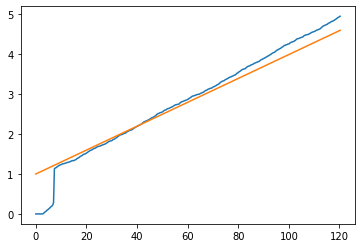

In [89]:
exceedThresh = np.sum(np.array(simAct)>0.01, axis=(0,2))/float(nRuns)
plt.plot(times, exceedThresh)
plt.plot(times, 1.*vMF*times/sep+1.)